# Load the globular cluster catalog

In [1]:
import tstrippy
import numpy as np

These data were taken from [Bumgardt's website](https://people.smp.uq.edu.au/HolgerBaumgardt/globular/). I extracted these data and reformated them into a fits file. This file is stored in `tstrippy/data/2023-03-28-merged.fits`. The file name is the date when I extracted the data from the website and it is *merged* because I took the columns I needed from the kinematic parameters and the structural parameters. 

In [2]:
GCdata=tstrippy.Parsers.baumgardtMWGCs().data

The data columns are the:

- **RA**: Right Ascension
- **DEC**: Declination
- **Rsun**: distance to the sun
- **RV**: Line-of-Sight velocity (radial velocity)
- **mualpha**: $\mu_{\alpha *}$=$\mu_{\alpha}\cos(\delta)$ the proper motion in right ascension
- **mu_delta**: $\mu_{\delta}$ the proper motion in declination
- **rhopmrade**: $\rho_{\alpha,\delta}$, the correlation coefficient between the proper motions of the right ascension and declination
- **Mass**: $M_\odot$ the mass of the globular cluster in solar masses
- **rh_m**: the half mass radius of the globular cluster

and each of which have their associated uncertainties.

In [3]:
for key in GCdata.keys():
    print(key)

Cluster
RA
DEC
Rsun
ERsun
RV
ERV
mualpha
ERmualpha
mu_delta
ERmu_delta
rhopmrade
Mass
DM
rh_m


## Sampling the uncertainties
You can pick a globular cluster and sample its covariance matrix. Note that there are no uncertainties reported the RA and DEC, since their uncertainties are orders of magnitude lower than the other quantities. Additionally, no uncertainty was reported for the half mass radius. 

In [4]:
targetGC = "NGC5139"
Nsamples = 100
GCobj=tstrippy.Parsers.baumgardtMWGCs()
mean,cov=GCobj.getGCCovarianceMatrix(targetGC)
samples = np.random.multivariate_normal(mean, cov, Nsamples)
RA_all,DEC_all,Rsun_all,RV_all,mualpha_all,mu_delta_all,Mass_all,rh_m_all=samples.T

Here, I'll make the plot nicer

In [5]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
# Function to plot an ellipse
def plot_cov_ellipse(mean, cov, ax, nstd=2, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance matrix (`cov`)
    and mean (`mean`).
    """
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = (plt.matplotlib.transforms.Affine2D()
              .rotate_deg(45)
              .scale(scale_x, scale_y)
              .translate(mean[0], mean[1]))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

/tmp/ipykernel_158317/2341453090.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])


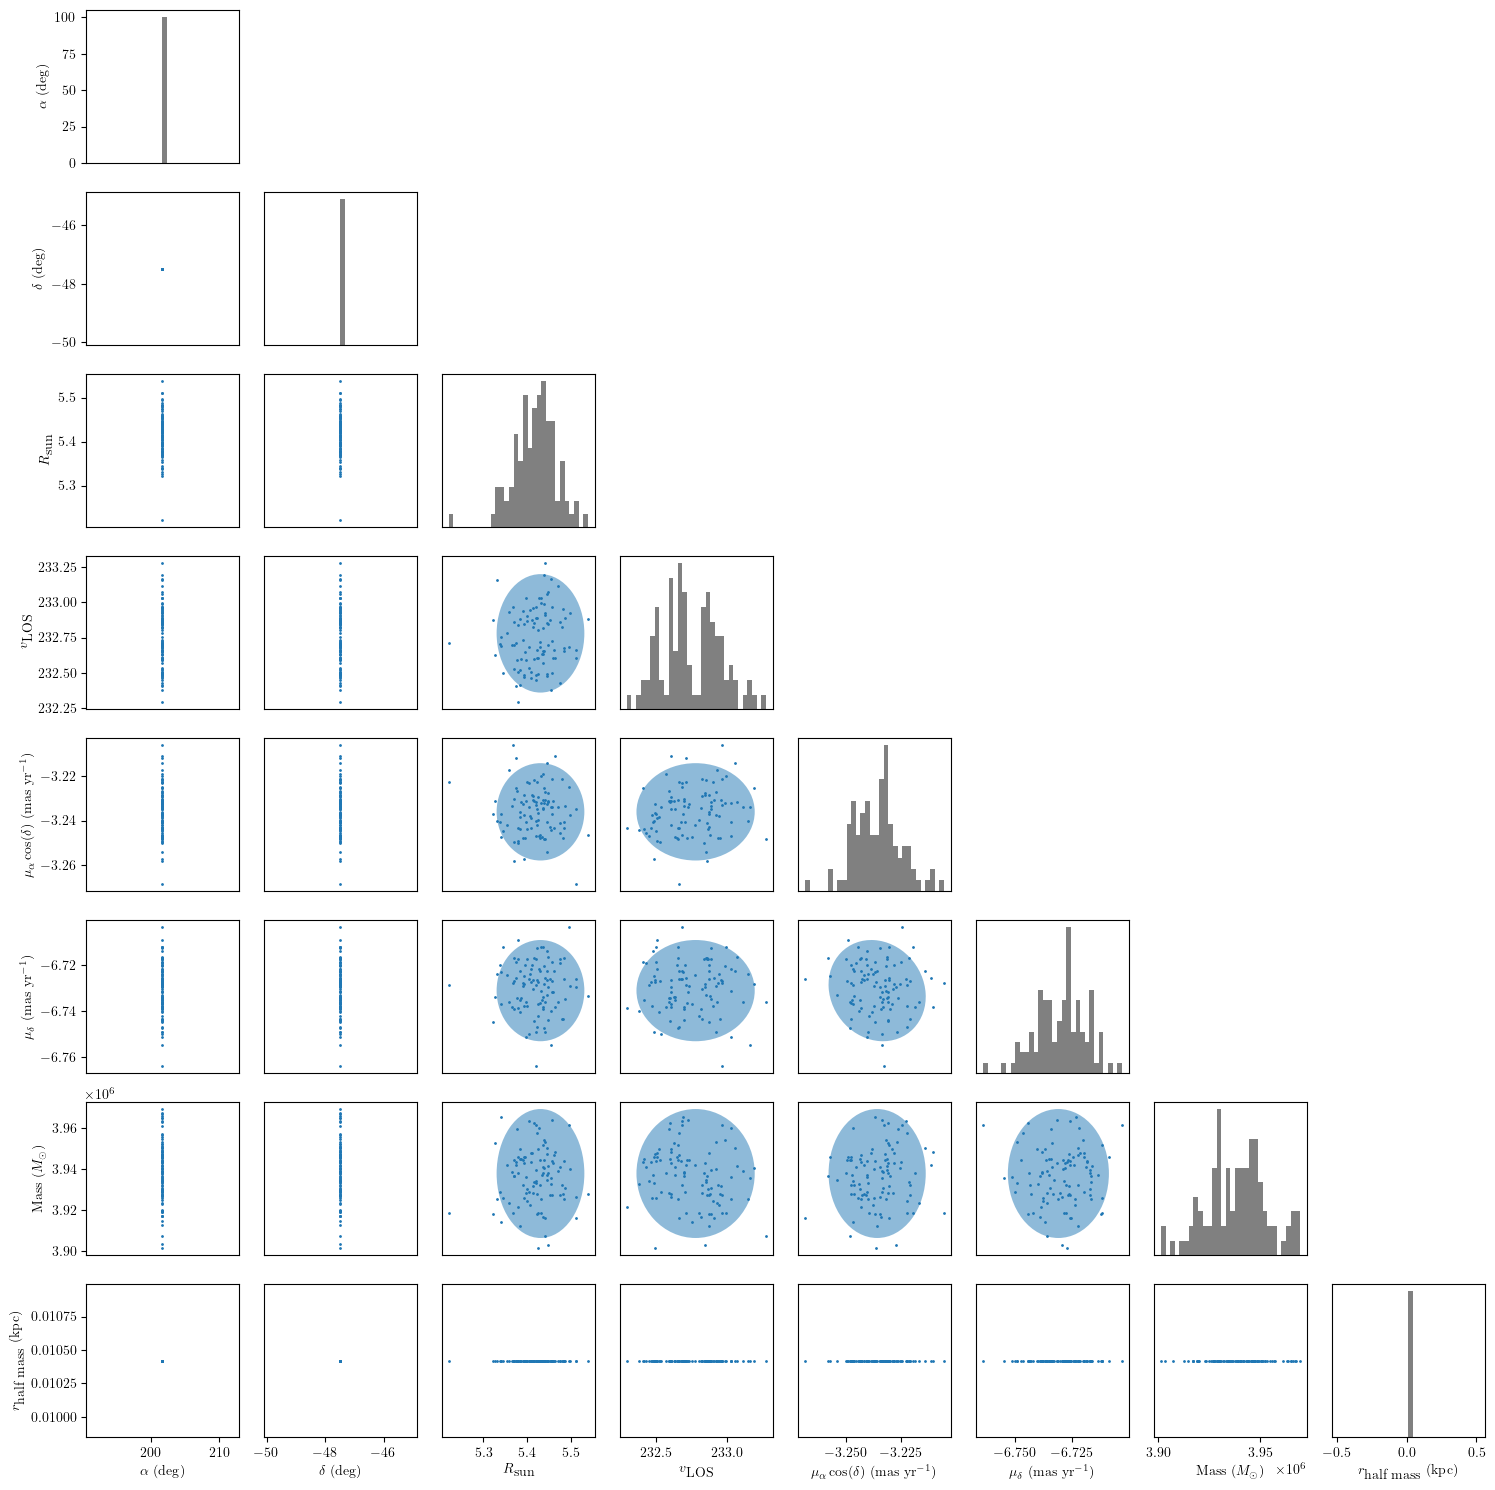

In [6]:
# Define the arrays
data = np.vstack([RA_all, DEC_all, Rsun_all, RV_all, mualpha_all, mu_delta_all, Mass_all, rh_m_all]).T
labels = [r'$\alpha$ $(\deg)$', '$\delta$ $(\deg)$', r'$R_{\textrm{sun}}$', r'$v_{\textrm{LOS}}$', r'$\mu_{\alpha}\cos(\delta)$ (mas yr$^{-1}$)', r'$\mu_{\delta}$ (mas yr$^{-1}$)', r'Mass $(M_{\odot})$', r'$r_{\textrm{half mass}}$ (kpc)']

# Create the corner plot
fig, axes = plt.subplots(len(labels), len(labels), figsize=(15, 15))

for i in range(len(labels)):
    for j in range(i+1):
        if i == j:
            axes[i, j].hist(data[:, i], bins=30, color='gray')
        else:
            axes[i, j].scatter(data[:, j], data[:, i], s=1)
            if i > j:
                plot_cov_ellipse(mean[[j, i]], cov[[j, i]][:, [j, i]], axes[i, j],alpha=0.5)
        if i < len(labels) - 1:
            axes[i, j].set_xticks([])
        else:
            axes[i, j].set_xlabel(labels[j])
        if j > 0:
            axes[i, j].set_yticks([])
        else:
            axes[i, j].set_ylabel(labels[i])

    for j in range(i+1, len(labels)):
        axes[i, j].axis('off')
        
fig.tight_layout()
plt.show()